# Theoretical lower and upper bounds for medians

This notebook is divided in two part.
1) First part is used to generate Figures 1 and 2 of the paper "Robust Consensus in Ranking Data Analysis: Definitions, Properties and Computational Issues".
2) Second part needs first part to run, and is used to generate Figure 4 of the same paper.

For the first part:


The first two cells are loading the relevant libraries and defining usefull functions.

The following two cells output the plots for the Figures

### Libraries

In [ ]:
%pylab
%matplotlib inline
import itertools
import torch
from matplotlib.patches import Patch

### Useful functions

In [2]:
def e_i(i, d=24):
    x = np.zeros(d)
    x[i] = 1.0
    return x

def kendall_tau(y, sigma):
    n = len(sigma)
    sigma_inv = np.argsort(sigma)
    y_inv = np.argsort(y)
    sigma_pairs = (sigma_inv[:, np.newaxis] > sigma_inv[np.newaxis, :]).astype(int)
    y_pairs = (y_inv[:, np.newaxis] > y_inv[np.newaxis, :]).astype(int)
    return np.sum(np.abs(sigma_pairs-y_pairs))/n/(n-1)

def spearman_rho(y, sigma):
    n = len(sigma)
    sigma_inv = np.argsort(sigma)
    y_inv = np.argsort(y)
    return 3 * np.linalg.norm(y_inv - sigma_inv, ord=2)**2 / n / (n**2 - 1)

def spearman_footrule(y, sigma):
    n = len(sigma)
    sigma_inv = np.argsort(sigma)
    y_inv = np.argsort(y)
    return np.linalg.norm(y_inv - sigma_inv, ord=1) / 8

def loss_matrix(d, all_ranks):
    n_fact = np.shape(all_ranks)[0]

    D = np.zeros((n_fact,n_fact))
    for i in range(n_fact):
        for j in range(n_fact):
            sigma = all_ranks[i]
            nu = all_ranks[j]
            D[i,j] = d(sigma, nu)  
    return D

def median(p, D):
    return e_i(np.argmin(p @ D))

def at_delta(i_star, i, delta, D):
    return (i_star @ (D @ i)) >= delta


## Lower bound functions
def lb_not_opt(p, sigma, nu, D):
    return (p @ (D @ sigma) - p @ D @ nu) / np.linalg.norm(D @ (sigma - nu), ord=np.inf)

def lb(p, delta, D, M):
    e_i_star = median(p, D)
    val_ij = np.ones((n_fact, n_fact)) * np.inf
    for i in range(n_fact):
        if at_delta(e_i_star, e_i(i), delta, M):
            val_ij[i,:] = 0
            for j in range(n_fact):
                if np.linalg.norm(D @ (e_i(i) - e_i(j)), ord=np.inf) > 0:
                    val_ij[i,j] = lb_not_opt(p, e_i(i), e_i(j), D)
    return np.min(np.max(val_ij, axis=-1))


## Upper bound functions
def ub_not_opt(p, sigma, nu, D):
    e_i_star = median(p, D)
    e_i_star_rev = median(p, -D)
    return 2*(p @ (D @ sigma) - p @ D @ nu) / (sigma @ D @ e_i_star + nu @ D @ e_i_star_rev - nu @ D @ e_i_star - sigma @ D @ e_i_star_rev)

def ub(p, delta, D, M):
    e_i_star = median(p, D)
    e_i_star_rev = median(p, -D)
    val_ij = np.ones((n_fact, n_fact)) * np.inf
    for i in range(n_fact):
        if at_delta(e_i_star, e_i(i), delta, M):
            val_ij[i,:] = 0
            for j in range(n_fact):
                if (e_i(i) @ D @ e_i_star + e_i(j) @ D @ e_i_star_rev - e_i(j) @ D @ e_i_star - e_i(i) @ D @ e_i_star_rev) > 0:
                    val_ij[i,j] = ub_not_opt(p, e_i(i), e_i(j), D)
    eps = np.min(np.max(val_ij, axis=-1))
    valid = 2*p @ median(p, D) >= eps
    return eps * valid + (1.0-valid)


### Experiments and plots

<Figure size 360x216 with 0 Axes>

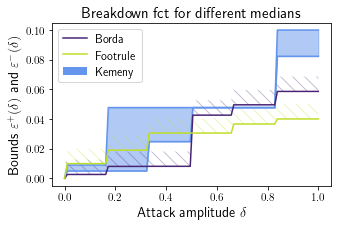

In [3]:
n_items = 4
n_fact = np.math.factorial(n_items)
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
all_ranks = np.asarray(all_ranks)

np.random.seed(682)
plt.figure(figsize=(5,3))

p = np.random.uniform(size=n_fact) 
p /= p.sum()

deltas = np.linspace(0,1,100)
M = loss_matrix(kendall_tau, all_ranks)

patches = []

y_max = 0.10

plt.rcParams.update({
    "text.usetex": True
        })
plt.figure(figsize=(5,3))
cm = plt.cm.get_cmap('viridis')
cm1 = cm(0.1)[:3]
cm2 = cm(0.9)[:3]

D = loss_matrix(kendall_tau, all_ranks)
ubs = [ub(p, delta, D, M) for delta in deltas]
lbs = [lb(p, delta, D, M) for delta in deltas]
plt.plot(deltas, lbs, "-", c='cornflowerblue')
plt.plot(deltas, np.clip(ubs, a_min=0.0, a_max=y_max), "-", c='cornflowerblue')
plt.fill_between(deltas, lbs, np.clip(ubs, a_min=0.0, a_max=y_max), alpha=0.5, color='cornflowerblue')
patches.append(Patch(facecolor='cornflowerblue', edgecolor='none', alpha=1, label=r"Kemeny"))

D = loss_matrix(spearman_rho, all_ranks)
ubs = 0.5*np.ones_like(deltas)
lbs = np.array([lb(p, delta, D, M) for delta in deltas])
plt.plot(deltas, lbs, c=cm1, alpha = 1, label=r'Borda')
plt.fill_between(deltas, lbs, lbs+0.01, alpha=0.3, edgecolor=cm1, facecolor='none', hatch="\\\\", linewidth=0.0)

D = loss_matrix(spearman_footrule, all_ranks)
lbs = np.array([lb(p, delta, D, M) for delta in deltas])
plt.plot(deltas, lbs, c=cm2, alpha = 1, label=r'Footrule')
plt.fill_between(deltas, lbs, lbs+0.01, alpha=0.3, edgecolor=cm2, facecolor='none', hatch="\\\\", linewidth=0.0)

h, l = plt.gca().get_legend_handles_labels()
plt.legend(handles=h+patches, fontsize=12)
plt.xlabel(r"Attack amplitude $\delta$", fontsize=14)
plt.ylabel(r"Bounds $\varepsilon^+(\delta)$ and $\varepsilon^-(\delta)$", fontsize=14)
plt.title(r"Breakdown fct for different medians", fontsize=15)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

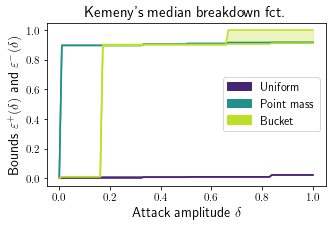

In [4]:
n_items = 4
n_fact = np.math.factorial(n_items)
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
all_ranks = np.asarray(all_ranks)

np.random.seed(23)

deltas = np.linspace(0,1,100)
M = loss_matrix(kendall_tau, all_ranks)

patches = []

y_max = 0.3

D = loss_matrix(kendall_tau, all_ranks)

noise = np.random.uniform(size=n_fact) 
noise /= noise.sum()

plt.rcParams.update({
    "text.usetex": True
        })
plt.figure(figsize=(5,3))
cm = plt.cm.get_cmap('viridis')

p = 0.1*noise + 0.9*np.ones(n_fact)/n_fact
ubs = [ub(p, delta, D, M) for delta in deltas]
lbs = [lb(p, delta, D, M) for delta in deltas]
plt.plot(deltas, lbs, "-", c=cm(0.1))
plt.plot(deltas, ubs, "-", c=cm(0.1))
plt.fill_between(deltas, lbs, ubs, alpha=0.3, color=cm(0.1))
patches.append(Patch(facecolor=cm(0.1), edgecolor=cm(0.1), alpha=1, label='Uniform'))

p = 0.1*noise + 0.9*e_i(0)
ubs = [ub(p, delta, D, M) for delta in deltas]
lbs = [lb(p, delta, D, M) for delta in deltas]
plt.plot(deltas, lbs, "-", c=cm(1/2))
plt.plot(deltas, ubs, "-", c=cm(1/2))
plt.fill_between(deltas, lbs, ubs, alpha=0.3, color=cm(1/2))
patches.append(Patch(facecolor=cm(1/2), edgecolor=cm(1/2), alpha=1, label='Point mass'))

p = 0.1*noise + 0.45*e_i(0) + 0.45*e_i(1)
ubs = [ub(p, delta, D, M) for delta in deltas]
lbs = [lb(p, delta, D, M) for delta in deltas]
plt.plot(deltas, lbs, "-", c=cm(0.9))
plt.plot(deltas, ubs, "-", c=cm(0.9))
plt.fill_between(deltas, lbs, ubs, alpha=0.3, color=cm(0.9))
patches.append(Patch(facecolor=cm(0.9), edgecolor=cm(0.9), alpha=1, label='Bucket'))


h, l = plt.gca().get_legend_handles_labels()
plt.legend(handles=h+patches, fontsize=12)
plt.xlabel(r"Attack amplitude $\delta$", fontsize=14)
plt.ylabel(r"Bounds $\varepsilon^+(\delta)$ and $\varepsilon^-(\delta)$", fontsize=14)
plt.title(r"Kemeny's median breakdown fct.", fontsize=15)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.show()

# Robustness at different levels

The next cells are used to output Figure 4 of the paper "Robust Consensus in Ranking Data Analysis:
Definitions, Properties and Computational Issues".

The first cells are loading the relevant librairies and defining useful functions.

The last 3 cells launch experiment for Kemeny's median, for the Downward Merge algorithm, and plot all the results

### Librairies

In [ ]:
from operator import itemgetter
from app.launcher_classic import launch_exp, pairwise_matrix

In [6]:
%load_ext autoreload
%autoreload 2

### Useful function

In [7]:
def get_res(p_torch, thresholds_, dist="erm", epochs=10000, w="", save=False, dist_type_sym=False, norm_type="1", deltas=np.linspace(0,6,13)):

    res_thresholds = dict()
    for a_ in thresholds_:
        thresholds = [a_.item()]
        print(f"THRESHOLD : {thresholds}")
        eps_list_all = list()
        alt_eps_list_all = list()

        for delta in deltas:
            print(f"Delta = {delta}")
            perf_list, eps_list1, eps_list2, alt_eps_list1, alt_eps_list2, dict_training = launch_exp(dist,
                        p_torch, w=w, delta=delta, thresholds_=thresholds, epochs=epochs, save=save, dist_type_sym=dist_type_sym,
                        norm_type=norm_type, nb_simu_training=25, exp_type="unimodal")
            eps_list_all.append(eps_list1[0].item())
            alt_eps_list_all.append(alt_eps_list1[0].item())
        res_thresholds[thresholds[0]] = {"full":eps_list_all, "alt":alt_eps_list_all}
    
    return res_thresholds

def myplot(p, res_dict, res_dict_additional=None, save=False, deltas=np.linspace(0,6,13)):
    plt.rcParams.update({
    "text.usetex": True
        })
    cm = plt.cm.get_cmap('Reds')
    cm(0.5)

    deltas2 = np.linspace(0,1,100)
    M = loss_matrix(spearman_footrule, all_ranks)

    patches = []

    D = loss_matrix(kendall_tau, all_ranks)
    ubs = [ub(p, delta, D, M) for delta in deltas2]
    lbs = [lb(p, delta, D, M) for delta in deltas2]
    plt.fill_between(deltas2, lbs, ubs, alpha=1.0, color='b')
    patches.append(Patch(facecolor='b', edgecolor='none', alpha=1.0, label=r'Kemeny bounds $\varepsilon^+(\delta)$ and $\varepsilon^-(\delta)$', lw=3))
    plt.axhline(2*p @ median(p, D), color='b', alpha=1.0, linestyle='--')

    plt.xlabel(r"Attack amplitude $\delta$", fontsize=14)
    plt.ylabel(r"Attack budget $\varepsilon(\delta)$ ", fontsize=14)
    
    for k, threshold in enumerate(res_dict.keys()):
        my_ys = list()
        for i, (e_full, e_alt) in enumerate(zip(res_dict[threshold]["full"], res_dict[threshold]["alt"])):
            my_ys.append(e_full/2.0)
        
        if len(list(res_dict.keys())) > 1:
            plt.plot(np.asarray(deltas)/6, my_ys, "o-", color=cm((k+1/len(list(res_dict.keys())))), label=r"$\varepsilon^{\gamma}_p(\delta)$ (exp.) - "+str(np.round(threshold, 3)), alpha=1.0, linewidth=0.5, ms=8)
        else:
            plt.plot(np.asarray(deltas)/6, my_ys, "x-", color="cornflowerblue", label=r"$\varepsilon^{\gamma}_p(\delta)$ (exp.) - Kemeny", alpha=1.0, linewidth=0.5, ms=11)
    
    if res_dict_additional is not None:
        for k, threshold in enumerate(res_dict_additional.keys()):
            my_ys = list()
            for i, (e_full, e_alt) in enumerate(zip(res_dict_additional[threshold]["full"], res_dict_additional[threshold]["alt"])):
                my_ys.append(e_full/2.0)
            plt.plot(np.asarray(deltas)/6, my_ys, "o-", color=cm((k+1)/len(list(res_dict_additional.keys()))), label=r"$\varepsilon^{\gamma}_p(\delta)$ (exp.) - $\theta =$ "+str(np.round(threshold, 3)), alpha=1.0, linewidth=0.5, ms=8)
    
    h, l = plt.gca().get_legend_handles_labels()
    legend = plt.legend(title="Legend", fontsize=12, handles=h+patches)
    legend.get_title().set_fontsize('13')
    plt.title(r"Theoretical and experimental attack budgets", fontsize=15)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.show()
    
def get_mean_res_dict(res_all_dicts, thresholds_):
    res_dict_mean = dict()
    for threshold in thresholds_:
        res_dict_mean[threshold] = dict()
        all_deltas_full = list()
        all_deltas_alt = list()
        for key in res_all_dicts.keys():
            all_deltas_full.append(res_all_dicts[key][threshold]["full"])
            all_deltas_alt.append(res_all_dicts[key][threshold]["alt"])

        mean_full = [np.mean(list(map(itemgetter(k), all_deltas_full))) for k in range(len(all_deltas_full[0]))]
        mean_alt = [np.mean(list(map(itemgetter(k), all_deltas_alt))) for k in range(len(all_deltas_alt[0]))]
        res_dict_mean[threshold]["full"] = mean_full
        res_dict_mean[threshold]["alt"] = mean_alt
    return res_dict_mean

### Launching experiments and plots

In [8]:
# Distrib
np.random.seed(183)
noise = np.random.uniform(size=n_fact) 
noise /= noise.sum()
p = 0.1*noise + 0.45*e_i(0) + 0.45*e_i(1)
p_torch = torch.tensor(p)
torch_all_ranks = torch.tensor(all_ranks)
P = pairwise_matrix(p_torch, torch_all_ranks, n=4)
print(P)

thresholds_ = torch.tensor([0.05, 0.5])
deltas = np.array([0, 0.1, 0.25, 0.5, 1.0, 1.3, 1.4, 1.5, 1.6, 1.7, 3, 4, 5, 6])

tensor([[0.0000, 0.9539, 0.9527, 0.9506],
        [0.0461, 0.0000, 0.9479, 0.9524],
        [0.0473, 0.0521, 0.0000, 0.5009],
        [0.0494, 0.0476, 0.4991, 0.0000]], dtype=torch.float64)


#### Kemeny's median

In [ ]:
res_erm_all = dict()
for i in range(10):
    res_erm = get_res(p_torch, thresholds_=torch.tensor([0.0]), dist="erm", epochs=5000, deltas=deltas)
    res_erm_all[i] = res_erm
res_dict_erm_mean = get_mean_res_dict(res_erm_all, thresholds_=[0.0])
myplot(p, res_dict_erm_mean, save=False, deltas=deltas)

#### Downward Merge Algorithm

In [ ]:
res_maxpair = get_res(p_torch, thresholds_=thresholds_, dist="maxpair", epochs=5000, deltas=deltas)
myplot(p, res_maxpair, save=False, deltas=deltas)

#### General plot

In [ ]:
myplot(p, res_dict_erm_mean, res_dict_additional=res_maxpair, save=False, deltas=deltas)